<a href="https://colab.research.google.com/github/ManveerTib/Cancer-Screening-Detection/blob/main/ChexNetModel_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Results saved to chexnet_results.csv


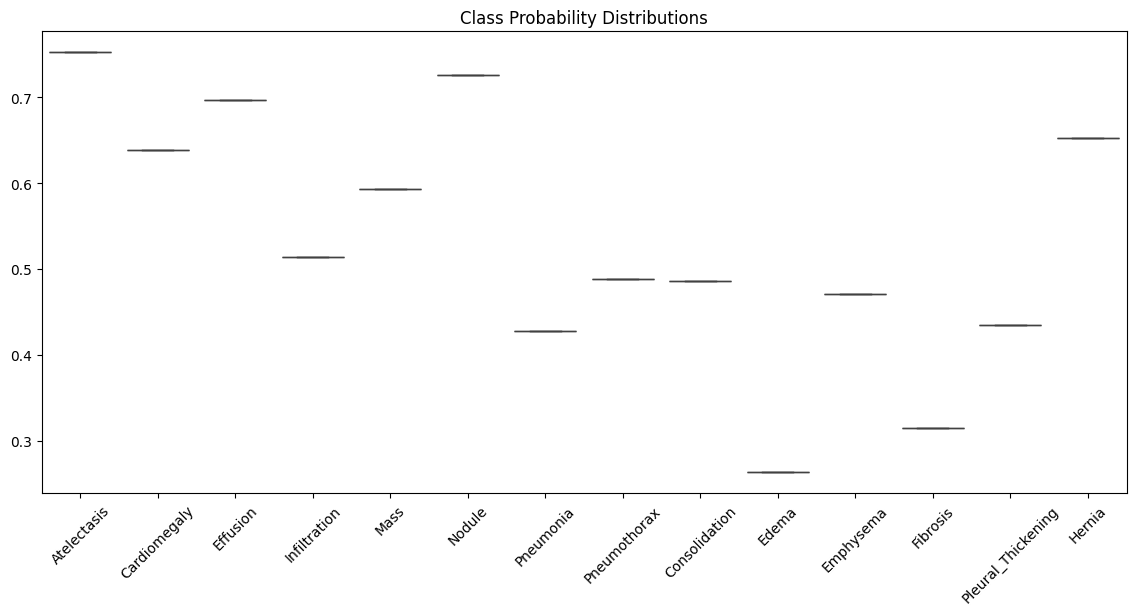

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


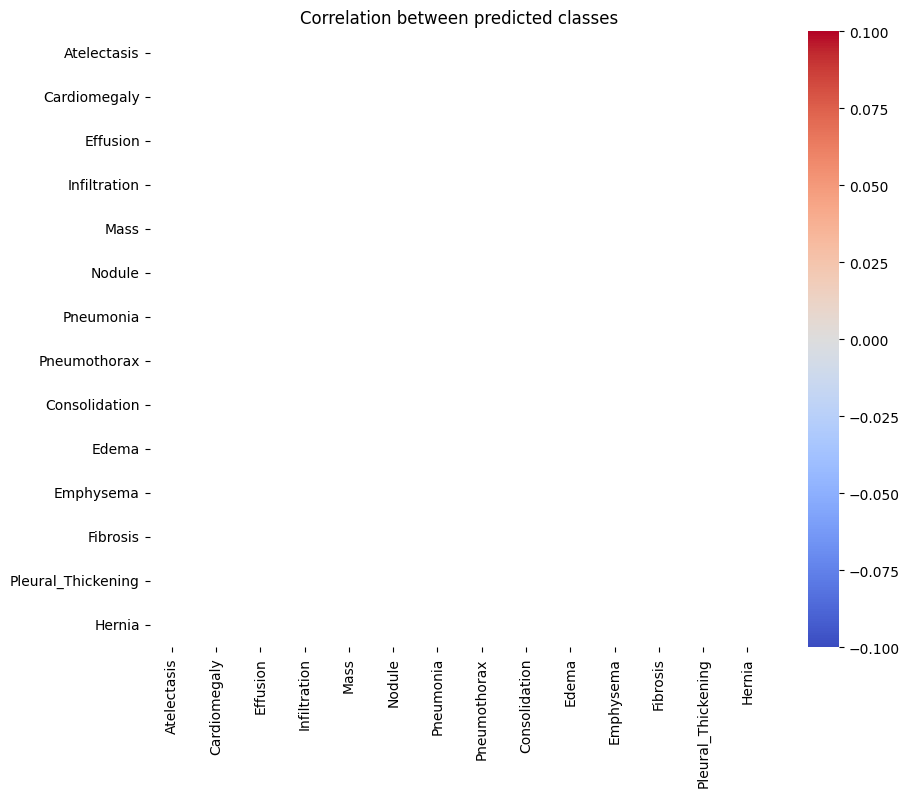

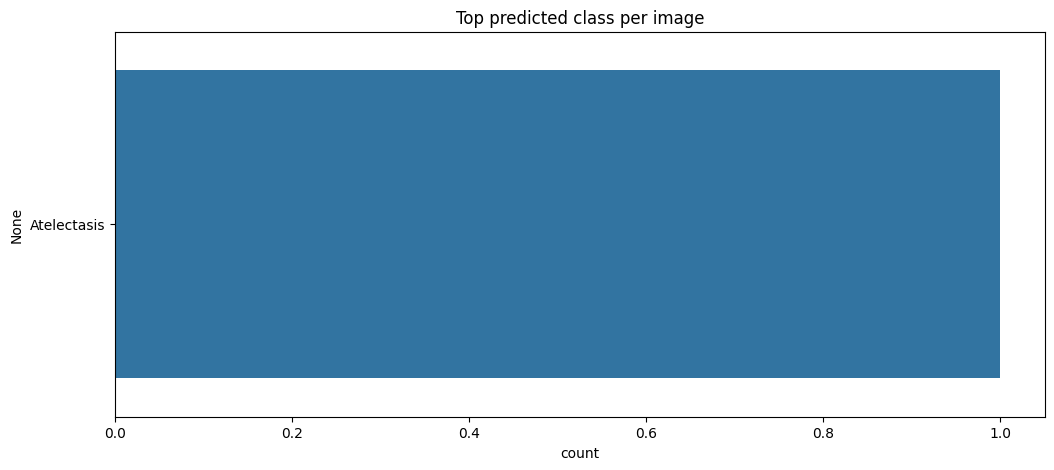

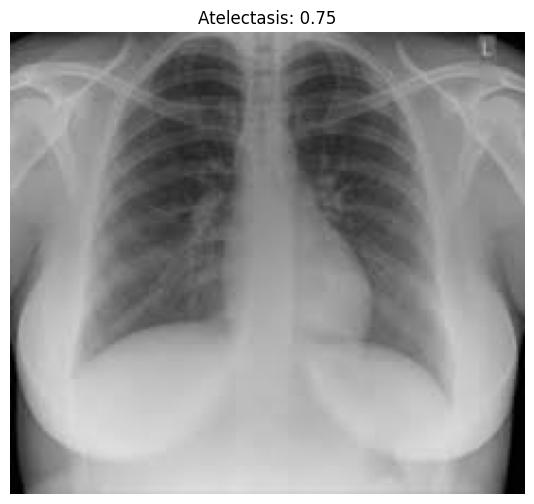

In [ ]:
# =========================
# 1. Install dependencies
# =========================
!pip install torch torchvision pandas matplotlib pillow scikit-learn seaborn --quiet

# =========================
# 2. Imports
# =========================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 3. Dataset class for URLs
# =========================
class ChestXrayURLDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = [
            "Atelectasis","Cardiomegaly","Effusion","Infiltration",
            "Mass","Nodule","Pneumonia","Pneumothorax","Consolidation",
            "Edema","Emphysema","Fibrosis","Pleural_Thickening","Hernia"
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        url = self.data.iloc[idx, 0]
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, url

# =========================
# 4. CheXNet model class
# =========================
class CheXNetModel(nn.Module):
    def __init__(self, num_classes=14):
        super(CheXNetModel, self).__init__()
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.densenet(x)

# =========================
# 5. Prepare transforms
# =========================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =========================
# 6. Load dataset and dataloader
# =========================
csv_file = "images_urls.csv"  # Replace with your CSV file path
dataset = ChestXrayURLDataset(csv_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

# =========================
# 7. Load model and move to GPU if available
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CheXNetModel(num_classes=14).to(device)
model.eval()
# Optionally load your trained weights:
# model.load_state_dict(torch.load('chexnet_best.pth', map_location=device))

# =========================
# 8. Run predictions
# =========================
results = []
with torch.no_grad():
    for images, urls in dataloader:
        images = images.to(device)
        outputs = model(images)
        outputs = outputs.cpu().numpy()
        for url, pred in zip(urls, outputs):
            entry = {"image_path": url}
            for cls, p in zip(dataset.classes, pred):
                entry[cls] = p
            results.append(entry)

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("chexnet_results.csv", index=False)
print("Results saved to chexnet_results.csv")

# =========================
# 9. Visualize predictions
# =========================
# Class probability distributions
plt.figure(figsize=(14,6))
sns.boxplot(data=results_df[dataset.classes])
plt.xticks(rotation=45)
plt.title("Class Probability Distributions")
plt.show()

# Heatmap of correlations between predicted classes
plt.figure(figsize=(10,8))
sns.heatmap(results_df[dataset.classes].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between predicted classes")
plt.show()

# Top predicted classes per image
top_classes = results_df[dataset.classes].idxmax(axis=1)
plt.figure(figsize=(12,5))
sns.countplot(y=top_classes, order=top_classes.value_counts().index)
plt.title("Top predicted class per image")
plt.show()

# =========================
# 10. Display sample images with top predictions
# =========================
num_samples = min(4, len(results_df))
plt.figure(figsize=(15,6))
for i in range(num_samples):
    url = results_df.loc[i, "image_path"]
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    top_class = results_df.loc[i, dataset.classes].idxmax()
    top_prob = results_df.loc[i, dataset.classes].max()

    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.title(f"{top_class}: {top_prob:.2f}")
    plt.axis("off")
plt.show()


In [ ]:
# =========================
# 11. Interactive per-image probability bar plot
# =========================
from ipywidgets import interact, IntSlider

def plot_image_probabilities(index):
    """
    Plots the image and a bar chart of all 14 class probabilities for the selected image.
    """
    if index >= len(results_df):
        print("Index out of range")
        return

    row = results_df.loc[index]
    url = row["image_path"]

    # Load image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Get class probabilities
    probs = row[dataset.classes].values
    classes = dataset.classes

    plt.figure(figsize=(12,5))

    # Show image
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Image Index: {index}")
    plt.axis("off")

    # Show bar chart
    plt.subplot(1,2,2)
    plt.barh(classes, probs, color='skyblue')
    plt.xlim(0,1)
    plt.xlabel("Probability")
    plt.title("Predicted Class Probabilities")
    plt.tight_layout()
    plt.show()

# Create an interactive slider to select the image index
interact(plot_image_probabilities, index=IntSlider(min=0, max=len(results_df)-1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='index', max=0), Output()), _dom_classes=('widget-interac…

In [ ]:
# =========================
# 12. Interactive per-image probability bar plot with top prediction highlighted
# =========================
from ipywidgets import interact, IntSlider

def plot_image_probabilities_highlight(index):
    """
    Plots the image and a horizontal bar chart of all 14 class probabilities
    for the selected image, highlighting the top predicted class.
    """
    if index >= len(results_df):
        print("Index out of range")
        return

    row = results_df.loc[index]
    url = row["image_path"]

    # Load image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Get class probabilities
    probs = row[dataset.classes].values
    classes = dataset.classes

    # Identify top predicted class
    top_idx = np.argmax(probs)
    top_class = classes[top_idx]
    top_prob = probs[top_idx]

    plt.figure(figsize=(12,5))

    # Show image
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Image Index: {index}\nTop Prediction: {top_class} ({top_prob:.2f})")
    plt.axis("off")

    # Show bar chart
    plt.subplot(1,2,2)
    bars = plt.barh(classes, probs, color='skyblue')
    bars[top_idx].set_color('orange')  # Highlight top predicted class
    plt.xlim(0,1)
    plt.xlabel("Probability")
    plt.title("Predicted Class Probabilities")
    plt.tight_layout()
    plt.show()

# Interactive slider to select image index
interact(plot_image_probabilities_highlight,
         index=IntSlider(min=0, max=len(results_df)-1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='index', max=0), Output()), _dom_classes=('widget-interac…